Here, we evaluate the accuracy of the Sigmoid activation function using the expression

sigmoid = 1/1 + e^-x

Accuracies

63.4, 84.3, 89.0, 92.4, 94.2, 94.3

In [ ]:
import multiprocessing 

import six
import numpy as np
import tensorflow.compat.v2 as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

!pip install git+https://github.com/google/qkeras

  Cloning https://github.com/google/qkeras to /tmp/pip-req-build-0_b0g0km
  Running command git clone -q https://github.com/google/qkeras /tmp/pip-req-build-0_b0g0km
     |████████████████████████████████| 174kB 20.7MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 6.8MB 38.8MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for QKeras: filename=QKeras-0.8.0-cp36-none-any.whl size=143338 sha256=3ded605b3f38314401ad421f9e533d3c43872feb995707f8bb64d16e7cd7b140
  Stored in directory: /tmp/pip-ephem-wheel-cache-i8cyp4iy/wheels/b4/74/1d/9456d62789716894a5edd7e342b4beaef69241ac584706c68d
  Created wheel for pyparser: filename=pyparser-1.0-cp36-none-any.whl size=4944 sha256=a0ea03dc97c1028d70b8a79665166dd683d5a397479103201ee52b035ec27a56
  Stored in directory: /root/.cache/pip/wheels/8a/1c/4f/9f66cd69719aa41c2684efae758d95db7803e9fe1f65146db1
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.w

In [ ]:
def get_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape + (1,)).astype("float32")
    x_test = x_test.reshape(x_test.shape + (1,)).astype("float32")

    x_train /= 256.0
    x_test /= 256.0

    x_mean = np.mean(x_train, axis=0)

    x_train -= x_mean
    x_test -= x_mean

    nb_classes = np.max(y_train)+1
    y_train = to_categorical(y_train, nb_classes)
    y_test = to_categorical(y_test, nb_classes)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = get_data()

In [ ]:
from qkeras import *
import qkeras
def CreateQModel(shape, nb_classes, intBits):
    x = x_in = Input(shape)

    x = Flatten(name="flatten")(x)
    x = QDense(256,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha = 1)".format(intBits),
        name="dense")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_1")(x)
    x = Activation('sigmoid')(x)
    x = QDense(128,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense2")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_2")(x)
    x = Activation('sigmoid')(x)
    x = QDense(128,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense3")(x)
    #x = QActivation("quantized_tanh(9, {})".format(intBits), name="act_3")(x)
    x = Activation('sigmoid')(x)
    x = QDense(nb_classes,
        kernel_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        bias_quantizer="quantized_bits(9, {} , alpha=1)".format(intBits),
        name="dense4")(x)
    x = Activation("softmax", name="softmax")(x)


    model = Model(inputs=x_in, outputs=x)
    
    return model

In [ ]:
from qkeras.utils import *
from tensorflow.keras.optimizers import Adam
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)
qmodel = CreateQModel(x_train.shape[1:], y_train.shape[-1], 1)
qmodel.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(0.0005),
    metrics=["accuracy"])
history = qmodel.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test[:5000], y_test[:5000]), verbose=False, callbacks=[callback])
model_save_quantized_weights(qmodel)
print ("Done")

... quantizing model
Done


In [ ]:
qmodel.evaluate(x_test[5000:], y_test[5000:])

157/157 [==============================] - 0s 3ms/step - loss: 0.0736 - accuracy: 0.9792


[0.073580302298069, 0.979200005531311]

In [ ]:
tangents = 2**(-1*np.arange(1.0, 100.0, 1.0))
lookup_arctanh = np.arctanh(tangents)

def modifiedCordicSigmoid(arr, iterations):
  '''
  Returns the quantized tanh of the supplied argument x
  '''
  xarr = 1.2075*np.ones(shape=(len(arr), len(arr[0])))
  yarr = np.zeros(shape = (len(arr), len(arr[0])))

  global  lookup_arctanh
  #current_vector = np.array([1.2075, 0])
  #z = x

  for i in range(1, iterations+1):
    m = -1
    sigma = np.sign(arr)
    
    xchange = m*sigma*2**(-i)*yarr
    ychange = sigma*2**(-i)*xarr
    arrchange = sigma*lookup_arctanh[i-1]

    xarr -= xchange
    yarr += ychange
    arr -= arrchange
    
    #x = current_vector[0]
    #y = current_vector[1]
    #xnew = x
    #ynew = y
    #xnew = xnew - m*sigma*2**(-i)*y
    #ynew = ynew + sigma*2**(-i)*x
    #z = z - sigma*lookup_arctanh[i-1]
    #current_vector = [xnew, ynew]

  eminusx = xarr - yarr
  #eminusx = xarr - yarr

  #temp1 = quantized_bits(9, 1, alpha=1)(ex - eminusx)
  #temp2 = quantized_bits(9, 1, alpha=1)(ex + eminusx)
  #return 1/(1+ex)
  temp = quantized_bits(9, 1, alpha=1)(1 + eminusx)
  return quantized_bits(9,1, alpha=1)(1/(1 + eminusx))

In [ ]:
x_test = x_test[5000:]
y_test = y_test[5000:]

In [ ]:
def epicGeneratePredictions(indices, iterations):
  global justAHolder, numOfIterations
  from keras import backend as K
  get_third_layer_output = K.function([qmodel.layers[0].input],
                                    [qmodel.layers[2].output])
 
  layer3_output = get_third_layer_output([x_test])[0]

  layer3_output = layer3_output[indices[0]: indices[1]]

  layer3_output = modifiedCordicSigmoid(layer3_output, iterations)

  input_shape = qmodel.layers[4].get_input_shape_at(0)
  layer_input = Input(shape=(256))
  x = layer_input
  x = qmodel.layers[4](x)
  qm4 = Model(layer_input, x)

  predictions = qm4.predict(layer3_output)

  predictions = modifiedCordicSigmoid(predictions, iterations)

  input_shape = qmodel.layers[6].get_input_shape_at(0)
  layer_input = Input(shape=(128))
  x = layer_input
  x = qmodel.layers[6](x)
  qm4 = Model(layer_input, x)

  predictions = qm4.predict(predictions)


  predictions = modifiedCordicSigmoid(predictions, iterations)

  input_shape = qmodel.layers[8].get_input_shape_at(0)
  layer_input = Input(shape=(128))
  x = layer_input
  x = qmodel.layers[8](x)

  qm4 = Model(layer_input, x)
  predictions = np.array(qm4.predict(predictions))

  #answer = np.zeros_like(predictions)
  #answer[len(predictions), predictions.argmax()] = 1
  a = predictions
  return (a == a.max(axis=1)[:,None]).astype(int)
  #return answer

  #return answer




In [ ]:
answerVectors = []
for iter in [2,3,4, 5, 6, 7]:
  answerVectors.append(epicGeneratePredictions([0, 1000], iter))
  print ("Done")

Done
Done
Done
Done
Done
Done


In [ ]:
accuracy = []
for i in answerVectors:
  correct = 0
  for j in range(1000):
    if (i[j] == y_test[j]).all():
      correct += 1
  accuracy.append(correct)

accuracy

[634, 843, 890, 924, 942, 943]

In [ ]:
y_test[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

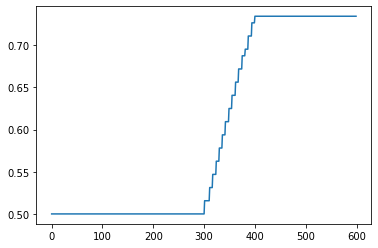

In [ ]:
#Experimenting with Bernoulli

toBePlotted = []
for i in np.arange(-3, 3, 0.01):
  toBePlotted.append(modifiedCordicTanh(np.array([[i]]), 5)[0][0])

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(toBePlotted)

In [ ]:
bernoulli(alpha=1.0)(3)

TypeError: ignored